<a href="https://colab.research.google.com/github/lauraliron/UFV_PFG/blob/main/Limpieza_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualización de datos

##Limpieza de datos

En esta parte del trabajo analizaremos la base de datos con la que trabajaremos a lo largo del proyecto. Nuestro objetivo es comprender las características principales de los datos, como el número total de pacientes, la detección de valores atípicos (outliers), la distribución de pacientes según su localización y los meses en los que se registra una mayor afluencia a urgencias.

Este análisis preliminar nos permitirá obtener una visión clara y detallada de los datos, lo que será fundamental para extraer conclusiones significativas. A partir de este conocimiento, podremos avanzar hacia la etapa de modelado y realizar predicciones mediante el uso de algoritmos avanzados, como XGBoost.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import numpy as np

####**1. Lectura del archivo.**

Como primer paso, cargamos el archivo .csv, mostramos los primeros datos y analizamos sus principales características. Las columnas con las que contamos son las siguientes:

* Fecha de atención: Indica el día, mes y año en que el paciente acudió a urgencias.
* Día de la semana: Nombre del día de la semana correspondiente a la fecha de atención.
* Nivel de triaje: Representa el nivel de urgencia de atención del paciente.
* Zona Básica de Salud: Zona de referencia médica asignada al paciente.
* Ámbito de procedencia: Clasificación del ámbito del paciente, ya sea urbano o rural.
* Hospital: Nombre del hospital donde fue atendido el paciente.
* Área: Área en la que se encuentra el hospital.
* Provincia: Provincia en la que se encuentra el hospital.
* Edad: Edad del paciente en años.
* Sexo: Sexo del paciente.

In [2]:
df = pd.read_csv('urgencias-hospitalarias-atendidas.csv', sep=';')
df.head()

,Fecha de atención,Día de la semana,Hora,Nivel de triaje,Zona Básica de Salud,Ámbito de procedencia,Hospital,Área,Provincia,Edad,Sexo
0,2023-01-25,MIÉRCOLES,13:19,5,Z.B.S. De la Puebla,Urbano,C.A.U. Palencia,Palencia,Palencia,61.0,Hombre
1,2023-01-27,VIERNES,22:00,3,Z.B.S. De la Puebla,Urbano,C.A.U. Palencia,Palencia,Palencia,20.0,Mujer
2,2023-01-18,MIÉRCOLES,02:53,5,Z.B.S. De la Puebla,Urbano,C.A.U. Palencia,Palencia,Palencia,38.0,Mujer
3,2023-01-17,MARTES,17:09,4,Z.B.S. De la Puebla,Urbano,C.A.U. Palencia,Palencia,Palencia,87.0,Hombre
4,2023-01-24,MARTES,11:13,4,Z.B.S. De la Puebla,Urbano,C.A.U. Palencia,Palencia,Palencia,43.0,Mujer


####**2. Datos faltantes.**

Contamos la cantidad de datos presentes en cada columna para identificar posibles datos faltantes.

In [3]:
df.count()

,0
Fecha de atención,2982756
Día de la semana,2982756
Hora,2982756
Nivel de triaje,2982756
Zona Básica de Salud,2838106
Ámbito de procedencia,2838106
Hospital,2982756
Área,2982756
Provincia,2982756
Edad,2977428


Observamos que no todas las columnas contienen la misma cantidad de datos, por lo que procederemos a identificar qué variables presentan valores nulos (NaN). Esto nos permitirá decidir si estos valores faltantes impactarán en nuestro análisis y, por lo tanto, si será necesario eliminarlos, o si podrán ser ignorados sin comprometer los resultados de nuestra investigación.

Por ahora, no sabemos cómo pueden influir los valores nulos en variables como la procedencia y la zona básica de salud, por lo que no eliminaremos esas filas en esta etapa. En cuanto a las variables como edad y sexo, estas podrían tener un impacto significativo en nuestro análisis, por lo que se evaluarán más adelante antes de tomar una decisión definitiva.

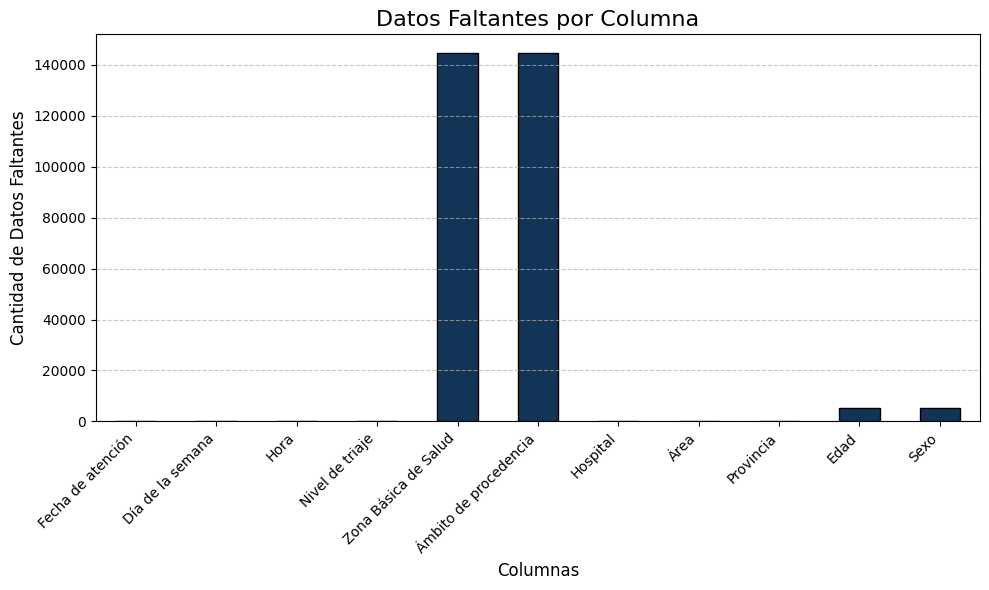

In [4]:
missing_data = df.isna().sum()

plt.figure(figsize=(10, 6))
missing_data.plot(kind='bar', color='#123456', edgecolor='black')  # Ajusta el color aquí
plt.title('Datos Faltantes por Columna', fontsize=16)
plt.xlabel('Columnas', fontsize=12)
plt.ylabel('Cantidad de Datos Faltantes', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', alpha=0.7, linestyle='--')
plt.tight_layout()
plt.show()


In [5]:
na_por_columna = df.isna().sum()

na_totales = df.isna().sum().sum()

print("Valores NaN por columna:")
print(na_por_columna)
print("\nNúmero total de valores NaN en el DataFrame:", na_totales)


Valores NaN por columna:
Fecha de atención             0
Día de la semana              0
Hora                          0
Nivel de triaje               0
Zona Básica de Salud     144650
Ámbito de procedencia    144650
Hospital                      0
Área                          0
Provincia                     0
Edad                       5328
Sexo                       5328
dtype: int64

Número total de valores NaN en el DataFrame: 299956


Vamos a analizar si coinciden los datos faltantes entre las columnas "Zona Básica de Salud" y "Ámbito de Procedencia", así como entre las columnas "Edad" y "Sexo".

In [6]:
na_coinciden = (df['Zona Básica de Salud'].isna() == df['Ámbito de procedencia'].isna()).all()

print("¿Coinciden los NaN entre 'Zona Básica de Salud' y 'Ámbito de procedencia'?", na_coinciden)

nan_coinciden = (df['Edad'].isna() == df['Sexo'].isna()).all()

print("¿Coinciden los NaN entre 'Edad' y 'Sexo'?", nan_coinciden)

¿Coinciden los NaN entre 'Zona Básica de Salud' y 'Ámbito de procedencia'? True
¿Coinciden los NaN entre 'Edad' y 'Sexo'? True


Hemos comprobado que coinciden los datos faltantes, ahora evaluaremos si los valores de Zona Básica de Salud y Ámbito de Procedencia pueden derivarse directamente del hospital, lo que podría hacerlas redundantes.

In [7]:
zona_ambito_hospital = df.groupby(['Área','Hospital'])[['Zona Básica de Salud', 'Ámbito de procedencia']].nunique()
print("Niveles únicos por hospital:\n", zona_ambito_hospital)

Niveles únicos por hospital:
                                       Zona Básica de Salud  \
Área             Hospital                                    
Bierzo           H. El Bierzo                          215   
Burgos           C.A.U. Burgos                         239   
                 H. Santiago Apóstol                   202   
                 H. Santos Reyes                       211   
León             C.A.U. León                           238   
Palencia         C.A.U. Palencia                       222   
Salamanca        C.A.U. Salamanca                      244   
Segovia          C.A. Segovia                          222   
Soria            C.A. Soria                            214   
Valladolid Este  H. Medina del Campo                   210   
                 H.C.U. Valladolid                     245   
Valladolid Oeste H.U. Río Hortega                      243   
Zamora           C.A. Zamora                           230   
Ávila            C.A. Ávila             

No es posible deducir la Zona Básica de Salud (ZBS) ni el ámbito de procedencia únicamente a partir del hospital, ya que un mismo hospital atiende a pacientes provenientes de diferentes ZBS y ámbitos. Tampoco podemos determinarlo exclusivamente a partir del área. Sin embargo, este análisis nos permite identificar qué hospitales están asociados a cada área, lo cual es útil para comprender mejor la distribución geográfica de la atención hospitalaria.

También vamos a ver como se asocian las áreas con cada provincia.

In [8]:
provincias_analisis = df.groupby('Provincia').agg({
    'Área': lambda x: x.unique()
})

provincias_analisis = provincias_analisis.reset_index()

provincias_analisis.columns = ['Provincia', 'Áreas']

provincias_analisis

,Provincia,Áreas
0,Burgos,[Burgos]
1,León,"[León, Bierzo]"
2,Palencia,[Palencia]
3,Salamanca,[Salamanca]
4,Segovia,[Segovia]
5,Soria,[Soria]
6,Valladolid,"[Valladolid Este, Valladolid Oeste]"
7,Zamora,[Zamora]
8,Ávila,[Ávila]


In [9]:
duplicados = df.duplicated()

total_duplicados = duplicados.sum()

print(f"Total de filas completamente duplicadas: {total_duplicados}")

if total_duplicados > 0:
    print("Filas duplicadas:")
    print(df[duplicados])
else:
    print("No hay filas completamente duplicadas en el DataFrame.")


Total de filas completamente duplicadas: 0
No hay filas completamente duplicadas en el DataFrame.


####**3. Análisis de pacientes por año.**

En esta sección analizaremos cómo se distribuyen las distintas variables. En primer lugar, nos interesa examinar cómo se distribuyen los datos a lo largo del tiempo. Para ello, creamos un gráfico que muestra la cantidad de los datos por año.

Estudiar esto es relevante debido  debido al estado de alarma por COVID-19. Este análisis nos permitirá identificar si los datos de ese año podrían introducir sesgos en nuestros resultados y, en caso necesario, considerar estrategias para manejarlos adecuadamente.

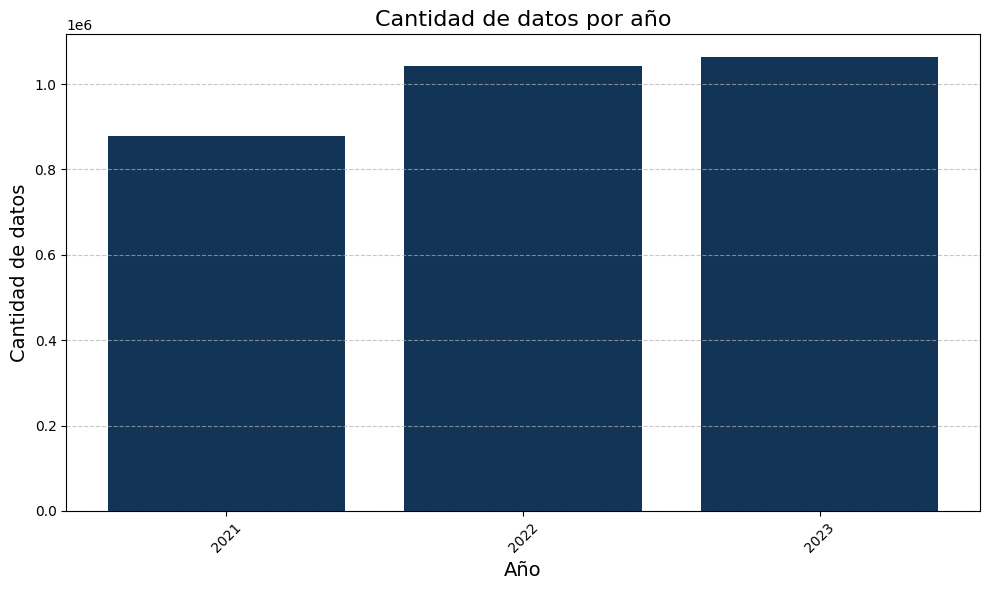

In [10]:
df['Fecha de atención'] = pd.to_datetime(df['Fecha de atención'], errors='coerce')

df['Año'] = df['Fecha de atención'].dt.year

conteo_por_año = df['Año'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(conteo_por_año.index, conteo_por_año.values, color='#123456')
plt.title("Cantidad de datos por año", fontsize=16)
plt.xlabel("Año", fontsize=14)
plt.ylabel("Cantidad de datos", fontsize=14)
plt.xticks(conteo_por_año.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

En 2021 se observa una menor cantidad de datos, lo que podría indicar que durante ciertos meses no se registraron datos en nuestra base de datos. Procederemos a comprobarlo, ya que inicialmente se esperaba un resultado contrario.

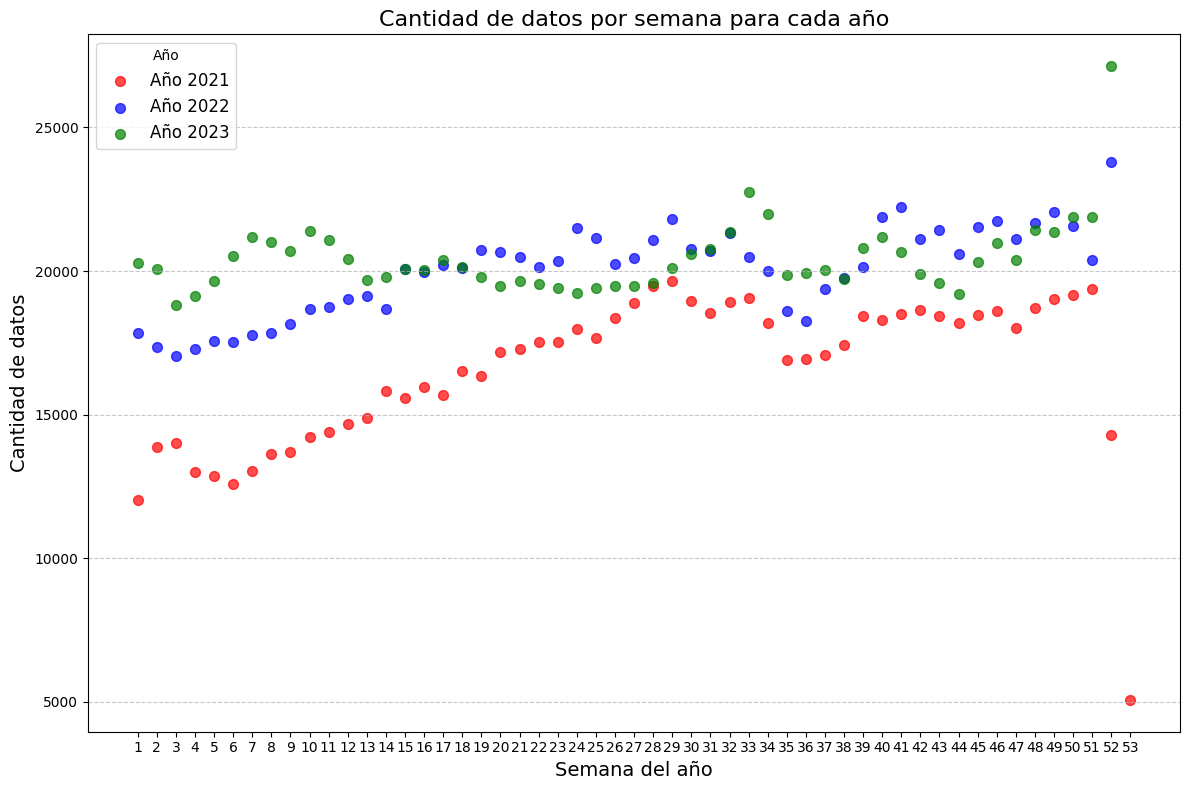

In [11]:
df['Fecha de atención'] = pd.to_datetime(df['Fecha de atención'], errors='coerce')

plt.figure(figsize=(12, 8))

for year, color in zip([2021, 2022, 2023], ['red', 'blue', 'green']):
    # Filtrar los datos del año
    datos_por_semana = (
        df[df['Fecha de atención'].dt.year == year]
        .groupby(df['Fecha de atención'].dt.isocalendar().week)
        .size()
    )


    plt.scatter(datos_por_semana.index, datos_por_semana.values, label=f"Año {year}", color=color, s=50, alpha=0.7)

# Personalización del gráfico
plt.title("Cantidad de datos por semana para cada año", fontsize=16)
plt.xlabel("Semana del año", fontsize=14)
plt.ylabel("Cantidad de datos", fontsize=14)
plt.xticks(range(1, 54))  # Semanas de 1 a 53
plt.legend(title="Año", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Verificamos que, efectivamente, durante todas las semanas del año 2021 se han registrado datos en nuestra base de datos. Sin embargo, para entender mejor la disminución en la cantidad total de datos de ese año, vamos a analizar si todos los hospitales tuvieron registros consistentes durante 2021. Esto nos permitirá identificar si la reducción de datos se debe a la falta de registros en ciertos hospitales o a algún otro motivo relacionado con la recopilación de información.

In [12]:
hospitales_2021 = sorted(df[df['Fecha de atención'].dt.year == 2021]['Hospital'].unique())
hospitales_totales = sorted(df['Hospital'].unique())

print("Hospitales en 2021:")
print("\n".join(hospitales_2021))
print(f"\nTotal de hospitales en 2021: {len(hospitales_2021)}\n")

print("Hospitales totales:")
print("\n".join(hospitales_totales))
print(f"\nTotal de hospitales totales: {len(hospitales_totales)}")

Hospitales en 2021:
C.A. Segovia
C.A. Soria
C.A. Zamora
C.A. Ávila
C.A.U. Burgos
C.A.U. León
C.A.U. Palencia
C.A.U. Salamanca
H. El Bierzo
H. Medina del Campo
H. Santiago Apóstol
H. Santos Reyes
H.C.U. Valladolid
H.U. Río Hortega

Total de hospitales en 2021: 14

Hospitales totales:
C.A. Segovia
C.A. Soria
C.A. Zamora
C.A. Ávila
C.A.U. Burgos
C.A.U. León
C.A.U. Palencia
C.A.U. Salamanca
H. El Bierzo
H. Medina del Campo
H. Santiago Apóstol
H. Santos Reyes
H.C.U. Valladolid
H.U. Río Hortega

Total de hospitales totales: 14


In [13]:
datos_faltantes_2021 = df[df['Fecha de atención'].dt.year == 2021].isna().sum()
print("Datos faltantes en 2021:\n", datos_faltantes_2021)

Datos faltantes en 2021:
 Fecha de atención            0
Día de la semana             0
Hora                         0
Nivel de triaje              0
Zona Básica de Salud     40598
Ámbito de procedencia    40598
Hospital                     0
Área                         0
Provincia                    0
Edad                      3816
Sexo                      3816
Año                          0
dtype: int64


Vemos que hay registros en todos los hospitales durante 2021, por lo que descartamos que la falta de datos esté relacionada con la ausencia de registros en algún hospital específico. Sin embargo, sigue siendo extraño que, a pesar de la pandemia de COVID-19, haya un menor número de registros durante este año. Para explorar más a fondo este fenómeno, investigaremos cuál es el mes con menos pacientes en 2021 y trataremos de extraer conclusiones a partir de esta información.

Vamos a analizar la cantidad de pacientes que acudieron a urgencias por mes en cada año, con el objetivo de identificar a partir de qué mes los datos de 2021 comienzan a asemejarse a los de 2022 y 2023. Esto nos permitirá determinar desde qué punto podemos considerar que la base de datos es representativa y adecuada para su análisis sin verse afectada por posibles anomalías relacionadas con la pandemia de COVID-19.

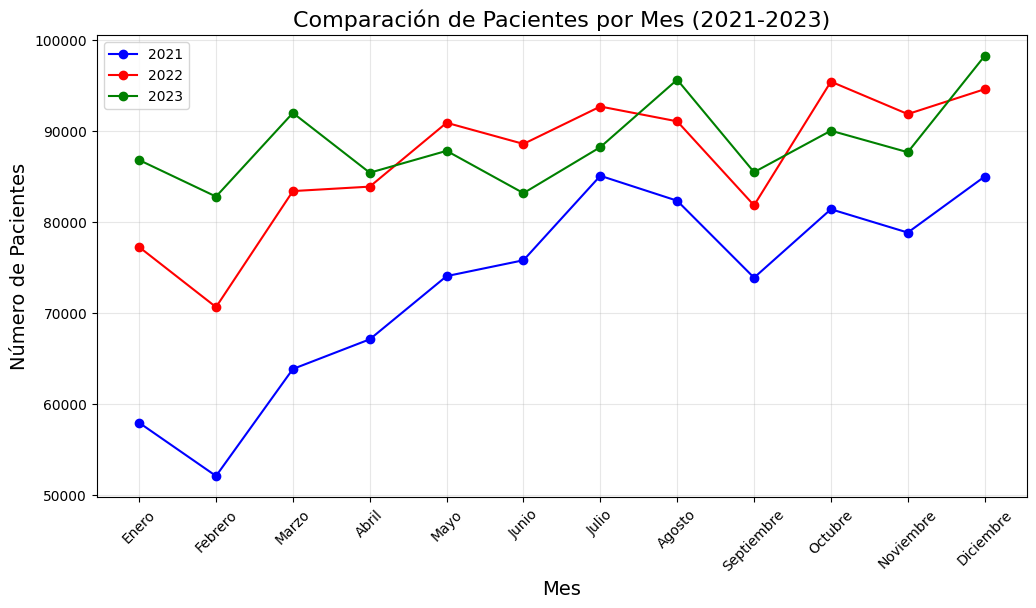

In [14]:
# Contar la cantidad de pacientes por mes en cada año
pacientes_por_mes_2021 = df[df['Fecha de atención'].dt.year == 2021]['Fecha de atención'].dt.month.value_counts().sort_index()
pacientes_por_mes_2022 = df[df['Fecha de atención'].dt.year == 2022]['Fecha de atención'].dt.month.value_counts().sort_index()
pacientes_por_mes_2023 = df[df['Fecha de atención'].dt.year == 2023]['Fecha de atención'].dt.month.value_counts().sort_index()

# Crear un array con los meses del año (1 a 12)
meses = np.arange(1, 13)

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(meses, pacientes_por_mes_2021, marker='o', linestyle='-', label='2021', color='blue')
plt.plot(meses, pacientes_por_mes_2022, marker='o', linestyle='-', label='2022', color='red')
plt.plot(meses, pacientes_por_mes_2023, marker='o', linestyle='-', label='2023', color='green')

# Configuración del gráfico
plt.title("Comparación de Pacientes por Mes (2021-2023)", fontsize=16)
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Número de Pacientes", fontsize=14)
plt.xticks(meses, ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'], rotation=45)
plt.legend()
plt.grid(alpha=0.3)

# Mostrar el gráfico
plt.show()


Vemos que a partir de mayo los datos de 2021 comienzan a asemejarse a los de los años siguientes, lo que sugiere que a partir de ese mes la base de datos puede considerarse representativa y sin anomalías significativas relacionadas con la pandemia de COVID-19. Para asegurarnos de ello, realizaremos un análisis cuantitativo mediante la comparación de las diferencias porcentuales entre los datos de 2021 y los de 2022 y 2023.

A través de este análisis, podremos verificar si el punto de inflexión observado en el gráfico anterior se mantiene en una comparación más detallada, confirmando si mayo es efectivamente el mes a partir del cual los datos de 2021 pueden utilizarse sin sesgos.

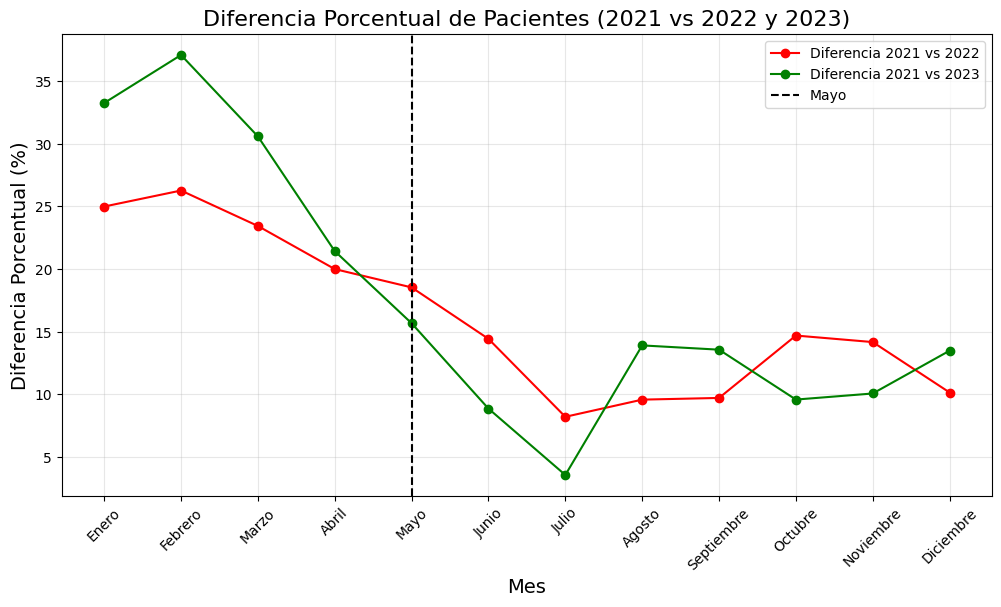

In [15]:
# Crear un DataFrame con los datos de pacientes por mes en cada año
datos_pacientes = pd.DataFrame({
    'Mes': np.arange(1, 13),
    '2021': pacientes_por_mes_2021,
    '2022': pacientes_por_mes_2022,
    '2023': pacientes_por_mes_2023
})

# Calcular diferencias porcentuales con respecto a 2021
datos_pacientes['Dif_2021_vs_2022'] = ((datos_pacientes['2022'] - datos_pacientes['2021']) / datos_pacientes['2022']) * 100
datos_pacientes['Dif_2021_vs_2023'] = ((datos_pacientes['2023'] - datos_pacientes['2021']) / datos_pacientes['2023']) * 100

# Graficar la diferencia porcentual mes a mes
plt.figure(figsize=(12, 6))
plt.plot(datos_pacientes['Mes'], datos_pacientes['Dif_2021_vs_2022'], marker='o', linestyle='-', label='Diferencia 2021 vs 2022', color='red')
plt.plot(datos_pacientes['Mes'], datos_pacientes['Dif_2021_vs_2023'], marker='o', linestyle='-', label='Diferencia 2021 vs 2023', color='green')

# Configuración del gráfico
plt.axvline(x=5, color='black', linestyle='--', label="Mayo")  # Línea vertical en junio
plt.title("Diferencia Porcentual de Pacientes (2021 vs 2022 y 2023)", fontsize=16)
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Diferencia Porcentual (%)", fontsize=14)
plt.xticks(np.arange(1, 13), ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'], rotation=45)
plt.legend()
plt.grid(alpha=0.3)

plt.show()


El gráfico confirma que en mayo se produce un punto de inflexión en la diferencia porcentual de pacientes entre 2021 y los otros dos años (2022 y 2023). Hasta abril, las diferencias son significativamente altas, indicando que la cantidad de registros en 2021 era considerablemente menor en comparación con los otros años. Sin embargo, a partir de mayo, estas diferencias disminuyen de manera constante hasta estabilizarse en valores más bajos, lo que sugiere que la tendencia de pacientes en 2021 comienza a asemejarse a la de 2022 y 2023.

Este análisis nos indica que los datos de 2021 anteriores a mayo podrían estar sesgados y no reflejar correctamente la demanda de urgencias debido a la pandemia. Por lo tanto, una decisión adecuada para trabajar con esta base de datos sería considerar únicamente los registros a partir de mayo de 2021 en adelante, asegurándonos así de que los datos utilizados sean más comparables y representativos de la realidad hospitalaria post-pandemia.

# **Elimino datos anteriores a Mayo de 2021**

Eliminamos los datos de 2021 y volvemos a ver la base de datos.

In [16]:
df['Fecha de atención'] = pd.to_datetime(df['Fecha de atención'], errors='coerce')

# Filtrar eliminando solo los meses de enero a abril de 2021
df = df[~((df['Fecha de atención'].dt.year == 2021) & (df['Fecha de atención'].dt.month < 5))]


####**4. Estudio las diferentes variables**

Ahora vamos a analizar las variables para verificar que todas tengan valores coherentes y consistentes. Nos enfocaremos en la variable "Edad" como ejemplo, observando sus máximos, mínimos, media y otros estadísticos relevantes. Este análisis nos permitirá identificar y eliminar datos que no sean reales, como valores negativos, extremadamente altos o que no correspondan con expectativas razonables. Este proceso es esencial para garantizar la calidad y la integridad de los datos antes de realizar cualquier análisis más profundo o tomar decisiones basadas en ellos.

In [17]:
df['Edad'].describe()

,Edad
count,2.736949e+06
mean,4.797926e+01
std,2.835378e+01
min,-1.000000e+00
25%,2.400000e+01
50%,5.000000e+01
75%,7.300000e+01
max,1.220000e+02


A través de este análisis, observamos que la media de edad de los pacientes es de 47 años. Sin embargo, también encontramos que el valor mínimo de edad es -1 año, lo cual no es lógico, y el máximo de edad es de 122 años. Al investigar un poco más, encontramos que la persona más longeva del mundo tiene 117 años, lo que indica que estos valores extremos no tienen sentido y son probablemente errores en los datos. Por lo tanto, procederemos a eliminar estos outliers para garantizar la calidad y coherencia de la información antes de continuar con el análisis.

In [18]:
edades_fuera_de_rango = df[(df['Edad'] < 0) | (df['Edad'] > 117)]

edades_fuera_de_rango.head()

,Fecha de atención,Día de la semana,Hora,Nivel de triaje,Zona Básica de Salud,Ámbito de procedencia,Hospital,Área,Provincia,Edad,Sexo,Año
1181300,2022-08-21,DOMINGO,09:21,Desconocido,NaN,NaN,H. Medina del Campo,Valladolid Este,Valladolid,122.0,Hombre,2022
2972694,2022-08-12,VIERNES,08:09,Desconocido,Z.B.S. Bembibre,Rural,H. El Bierzo,Bierzo,León,-1.0,Mujer,2022


In [19]:
# Filtrar solo los registros con edades válidas (entre 0 y 117 años)
df = df[(df['Edad'] >= 0) & (df['Edad'] <= 117)]

In [20]:
df['Edad'].describe()

,Edad
count,2.736947e+06
mean,4.797925e+01
std,2.835374e+01
min,0.000000e+00
25%,2.400000e+01
50%,5.000000e+01
75%,7.300000e+01
max,1.170000e+02


Una vez hemos limpiado la variable de edad, vamos a proceder a ver los dias de la semana

In [21]:
dias_esperados = ["LUNES", "MARTES", "MIÉRCOLES", "JUEVES", "VIERNES", "SÁBADO", "DOMINGO"]

dias_unicos = df['Día de la semana'].unique()

print("Días únicos en la columna:", dias_unicos)

dias_no_validos = [dia for dia in dias_unicos if dia not in dias_esperados]

if dias_no_validos:
    print("Días no válidos encontrados:", dias_no_validos)
else:
    print("Todos los días están escritos de forma adecuada.")

filas_dias_no_validos = df[df['Día de la semana'].isin(dias_no_validos)]

if not filas_dias_no_validos.empty:
    print("Filas con días no válidos:")
    print(filas_dias_no_validos.head())


Días únicos en la columna: ['MIÉRCOLES' 'VIERNES' 'MARTES' 'DOMINGO' 'LUNES' 'SÁBADO' 'JUEVES']
Todos los días están escritos de forma adecuada.


A continuación, el código verifica que no existan fechas inválidas, como el 30 de febrero, asegurando que todas las fechas en el DataFrame sean correctas y correspondan a días reales dentro de cada mes.

In [22]:
df['Fecha de atención'] = pd.to_datetime(df['Fecha de atención'], errors='coerce')

fechas_invalidas = df[df['Fecha de atención'].isna()]

if fechas_invalidas.empty:
    print("Todas las fechas son válidas.")
else:
    print("Fechas no válidas encontradas:")
    print(fechas_invalidas)

df['Día'] = df['Fecha de atención'].dt.day
df['Mes'] = df['Fecha de atención'].dt.month
df['Año'] = df['Fecha de atención'].dt.year


def verificar_dias_invalidos(df):
    problemas = []
    for año in df['Año'].unique():
        for mes in df['Mes'].unique():
            # Obtener último día del mes para el año dado
            ultimo_dia = calendar.monthrange(año, mes)[1]
            # Filtrar filas donde el día excede el último día del mes
            dias_invalidos = df[(df['Año'] == año) & (df['Mes'] == mes) & (df['Día'] > ultimo_dia)]
            if not dias_invalidos.empty:
                problemas.append(dias_invalidos)
    return problemas

problemas_dias = verificar_dias_invalidos(df)

if problemas_dias:
    print("Se encontraron fechas con días fuera de rango:")
    for problema in problemas_dias:
        print(problema)
else:
    print("No se encontraron días fuera de rango.")


Todas las fechas son válidas.
No se encontraron días fuera de rango.


Ahora realizamos la misma verificación con las horas, asegurándonos de que todas estén en un formato válido.

In [21]:
df['Hora'] = df['Hora'].astype(str)

# Función para verificar horas válidas
def es_hora_valida(hora):
    try:
        # Intentar convertir la hora al formato datetime.time
        pd.to_datetime(hora, format='%H:%M').time()
        return True
    except ValueError:
        return False

# Aplicar la función para identificar horas inválidas
df['Hora válida'] = df['Hora'].apply(es_hora_valida)

# Filtrar las horas inválidas
horas_invalidas = df[~df['Hora válida']]

if horas_invalidas.empty:
    print("Todas las horas son válidas.")
else:
    print("Horas inválidas encontradas:")
    print(horas_invalidas[['Fecha de atención', 'Hora']])

# Si no hay problemas con las horas, convertirlas a datetime.time para análisis adicional
if horas_invalidas.empty:
    df['Hora'] = pd.to_datetime(df['Hora'], format='%H:%M').dt.time

# Mostrar estadística de las horas
if horas_invalidas.empty:
    print("Hora más temprana:", df['Hora'].min())
    print("Hora más tardía:", df['Hora'].max())


Horas inválidas encontradas:
        Fecha de atención Hora
2798252        2022-08-27    :


Comprobamos que existe una hora inválida, por lo que la eliminamos del DataFrame para garantizar que solo queden registros con horas correctamente formateadas.

Estudiamos los niveles de triaje, primero veremos cuantos niveles de triaje tenemos. Esto nos serivira para ver si hay alguno que no concuerde

In [23]:
print(df['Nivel de triaje'].unique())

['5' '3' '4' '2' '1' 'Desconocido']


In [24]:
print(df['Nivel de triaje'].value_counts())

Nivel de triaje
4              1234343
3               875069
Desconocido     301913
5               198131
2               124267
1                 3224
Name: count, dtype: int64


Ahora vamos a entrar más en detalle en los datos que hay dentro del Nivel de triaje, podemos ver la cantidad de datos, la media de la edad

In [25]:
df_desconocidos = df[df['Nivel de triaje'] == 'Desconocido']
print(df_desconocidos.describe())
print(df_desconocidos.head())

                   Fecha de atención           Edad            Año  \
count                         301913  301913.000000  301913.000000   
mean   2022-06-01 10:01:39.565106432      39.527953    2021.872486   
min              2021-05-01 00:00:00       0.000000    2021.000000   
25%              2021-09-29 00:00:00       9.000000    2021.000000   
50%              2022-04-13 00:00:00      37.000000    2022.000000   
75%              2023-01-07 00:00:00      66.000000    2023.000000   
max              2023-12-31 00:00:00     117.000000    2023.000000   
std                              NaN      30.243361       0.787888   

                 Día            Mes  
count  301913.000000  301913.000000  
mean       15.759388       7.051194  
min         1.000000       1.000000  
25%         8.000000       5.000000  
50%        16.000000       7.000000  
75%        23.000000      10.000000  
max        31.000000      12.000000  
std         8.788354       3.218179  
    Fecha de atención Día d

Observamos que en los primeros datos se repiten el mismo año, ámbito de procedencia y zona de salud, por lo que vamos a verificar si el nivel de triaje "Desconocido" solo aparece cuando se cumple alguna de estas condiciones.

In [29]:
print(df_desconocidos['Año'].unique())

[2023 2021 2022]


In [28]:
print(df_desconocidos['Ámbito de procedencia'].unique())

['Urbano' 'Rural' nan]


In [27]:
print(df_desconocidos['Zona Básica de Salud'].unique())

['Z.B.S. De la Puebla' 'Z.B.S. Ponferrada IV' 'Z.B.S. Candeleda'
 'Z.B.S. Valderas' 'Z.B.S. Cervera de Pisuerga' 'Z.B.S. Soria Norte'
 'Z.B.S. José Aguado I' 'Z.B.S. Torquemada' 'Z.B.S. La Victoria'
 'Z.B.S. Circunvalación' 'Z.B.S. Rondilla I' 'Z.B.S. Huerta del Rey'
 'Z.B.S. Magdalena' 'Z.B.S. Villafrechós' 'Z.B.S. Tudela'
 'Z.B.S. Peñafiel' 'Z.B.S. Plaza del Ejército' 'Z.B.S. Pilarica'
 'Z.B.S. Mayorga de Campos' 'Z.B.S. Tórtola' 'Z.B.S. Gamazo'
 'Z.B.S. Villalón de Campos' 'Z.B.S. Íscar' 'Z.B.S. Toro'
 'Z.B.S. Benavente Sur' 'Z.B.S. Alcañices' 'Z.B.S. Villarrín'
 'Z.B.S. Segovia Rural' 'Z.B.S. Madrigal de las Altas Torres'
 'Z.B.S. Fontiveros' 'Z.B.S. Las Navas del Marqués' 'Z.B.S. Mombeltrán'
 'Z.B.S. Almazán' 'Z.B.S. Muñico' 'Z.B.S. Medina de Pomar'
 'Z.B.S. Sta. María del Páramo' 'Z.B.S. Guardo' 'Z.B.S. Laguna de Duero'
 'Z.B.S. Portillo' 'Z.B.S. Serrada' 'Z.B.S. Pisuerga'
 'Z.B.S. Eras de Renueva' 'Z.B.S. Miranda Oeste'
 'Z.B.S. Valladolid Rural II' 'Z.B.S. Casa del Barco' 'Z.B.

Ahora analizamos la variable 'Sexo' y observamos que hay más datos de mujeres que de hombres. Esta diferencia en la distribución de los datos debe ser considerada al momento de realizar el proyecto y extraer conclusiones, ya que podría influir en los resultados y en la interpretación de los análisis.

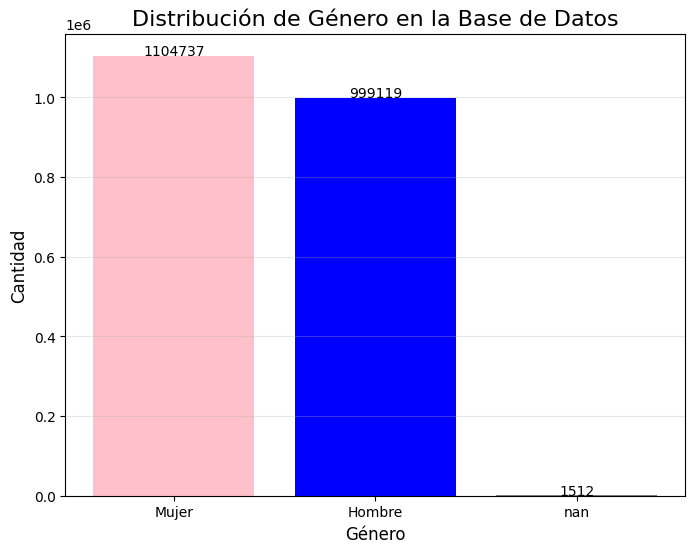

In [ ]:
genero_counts = df['Sexo'].value_counts(dropna=False)

# Crear los colores para cada categoría
colors = {'Hombre': 'blue', 'Mujer': 'pink', None: 'gray'}

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(genero_counts.index.astype(str), genero_counts.values, color=[colors.get(x, 'gray') for x in genero_counts.index])
plt.title('Distribución de Género en la Base de Datos', fontsize=16)
plt.xlabel('Género', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Agregar etiquetas a las barras
for i, count in enumerate(genero_counts.values):
    plt.text(i, count + 100, str(count), ha='center', fontsize=10)

plt.show()


Una vez hemos analizado todas las variables y eliminado los datos que no eran útiles o que podían sesgar el estudio, procedemos a examinar la información en profundidad para identificar patrones y extraer conclusiones relevantes.

##Análisis de datos


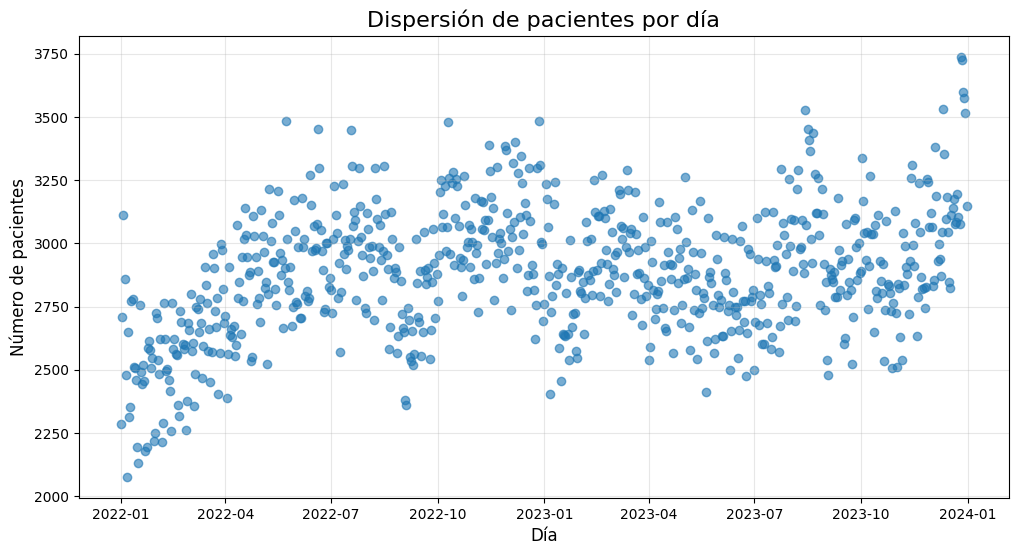

In [ ]:
df['Fecha de atención'] = pd.to_datetime(df['Fecha de atención'])

# Contar el número de pacientes por día
pacientes_por_dia = df['Fecha de atención'].value_counts().sort_index()

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 6))
plt.scatter(pacientes_por_dia.index, pacientes_por_dia.values, alpha=0.6)
plt.title('Dispersión de pacientes por día', fontsize=16)
plt.xlabel('Día', fontsize=12)
plt.ylabel('Número de pacientes', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Asegúrate de que la columna de fecha esté en formato datetime
df['Fecha de atención'] = pd.to_datetime(df['Fecha de atención'])

# Agrega una columna para el año
df['Año'] = df['Fecha de atención'].dt.year

# Contar el número de pacientes por día
pacientes_por_dia = df.groupby(['Año', 'Fecha de atención']).size()

# Encontrar el día con más pacientes para cada año
dia_mas_pacientes = pacientes_por_dia.groupby('Año').idxmax()
cantidad_pacientes = pacientes_por_dia.groupby('Año').max()

# Crear un DataFrame con los resultados
resultado = pd.DataFrame({
    'Día con más pacientes': dia_mas_pacientes,
    'Cantidad de pacientes': cantidad_pacientes
})

# Mostrar los resultados
print(resultado)


            Día con más pacientes  Cantidad de pacientes
Año                                                     
2022  (2022, 2022-05-23 00:00:00)                   3483
2023  (2023, 2023-12-26 00:00:00)                   3738


In [ ]:
# Asegúrate de que la columna de fecha esté en formato datetime
df['Fecha de atención'] = pd.to_datetime(df['Fecha de atención'])

# Agrega columnas para el año y el mes
df['Año'] = df['Fecha de atención'].dt.year
df['Mes'] = df['Fecha de atención'].dt.month

# Contar el número de pacientes por mes y año
pacientes_por_mes = df.groupby(['Año', 'Mes']).size()

# Encontrar el mes con más pacientes para cada año
mes_mas_pacientes = pacientes_por_mes.groupby('Año').idxmax()
cantidad_pacientes = pacientes_por_mes.groupby('Año').max()

# Crear un DataFrame con los resultados
resultado = pd.DataFrame({
    'Mes con más pacientes': mes_mas_pacientes,
    'Cantidad de pacientes': cantidad_pacientes
})

# Mostrar los resultados
print(resultado)


     Mes con más pacientes  Cantidad de pacientes
Año                                              
2022            (2022, 10)                  95423
2023            (2023, 12)                  98239


In [ ]:
# Asegúrate de que la columna de fecha esté en formato datetime
df['Fecha de atención'] = pd.to_datetime(df['Fecha de atención'])

# Agrega columnas para el año, mes y día
df['Año'] = df['Fecha de atención'].dt.year
df['Mes'] = df['Fecha de atención'].dt.month
df['Día'] = df['Fecha de atención'].dt.day

# Contar el número de pacientes por día y mes en cada año
pacientes_por_dia_mes = df.groupby(['Año', 'Mes', 'Día']).size()

# Encontrar el día y mes con menos pacientes para cada año
dia_mes_menos_pacientes = pacientes_por_dia_mes.groupby('Año').idxmin()
cantidad_menos_pacientes = pacientes_por_dia_mes.groupby('Año').min()

# Crear un DataFrame con los resultados
resultado_menos = pd.DataFrame({
    'Día y Mes con menos pacientes': dia_mes_menos_pacientes,
    'Cantidad de pacientes': cantidad_menos_pacientes
})

# Mostrar los resultados
print(resultado_menos)


     Día y Mes con menos pacientes  Cantidad de pacientes
Año                                                      
2022                  (2022, 1, 6)                   2077
2023                  (2023, 1, 6)                   2405


In [ ]:
# Asegúrate de que la columna de fecha esté en formato datetime
df['Fecha de atención'] = pd.to_datetime(df['Fecha de atención'])

# Crear columnas con el año y el mes
df['Año'] = df['Fecha de atención'].dt.year
df['Mes'] = df['Fecha de atención'].dt.month

# Contar el número total de pacientes por año y mes
pacientes_por_año_mes = df.groupby(['Año', 'Mes']).size()

# Encontrar el mes con menos pacientes para cada año
mes_menos_pacientes_por_año = pacientes_por_año_mes.groupby('Año').idxmin()
cantidad_menos_pacientes_por_año = pacientes_por_año_mes.groupby('Año').min()

# Mostrar resultados
for año, (año_mes) in mes_menos_pacientes_por_año.items():
    mes = año_mes[1]  # El segundo elemento del índice es el mes
    cantidad = cantidad_menos_pacientes_por_año[año]
    print(f"En el año {año}, el mes con menos pacientes fue el mes {mes} con {cantidad} pacientes.")


En el año 2022, el mes con menos pacientes fue el mes 2 con 70652 pacientes.
En el año 2023, el mes con menos pacientes fue el mes 2 con 82794 pacientes.
